In [1]:
import matplotlib.pyplot as plt
import os
from model.Unet import UNetWithDropout
from model import UNet
import torch
from dataset.SphDataset import Dataset3d
import numpy as np
from tqdm import tqdm
from scipy.ndimage import zoom
from util.metric import get_metric
import pandas as pd

# 生成表格

In [2]:
@torch.no_grad()
def test(model, dataloader, batch_size, input_size):
    device = next(iter(model.parameters())).device
    model.eval()
    tbar = tqdm(dataloader)
    dice_his, iou_his, assd_his = [], [], []
    for idx, (img, mask) in enumerate(tbar):
        img, mask = img[0], mask[0]
        h, w = img.shape[-2], img.shape[-1]
        batch_pred = []
        for batch in range(0, img.shape[0], batch_size):
            last = batch + batch_size
            batch_slices = img[batch:] if last >= img.shape[0] else img[batch:last]

            batch_slices = zoom(batch_slices, (1, 1, input_size / h, input_size / w), order=0,
                                mode='nearest')
            batch_slices = torch.from_numpy(batch_slices).to(device)
            output, _ = model(batch_slices)
            batch_pred_mask = output.argmax(dim=1).cpu()
            batch_pred_mask = zoom(batch_pred_mask, (1, h / input_size, w / input_size), order=0,
                                   mode='nearest')
            batch_pred.append(batch_pred_mask)

        pred_volume = np.concatenate(batch_pred)
        del batch_pred
        dice, iou, assd = get_metric(pred_volume, np.asarray(mask.squeeze(1)))

        tbar.set_description(
            f"EVAl | Dice:{dice:.3f} Mean IoU: {iou:.2f} asd: {assd:.2f} ")

        dice_his.append(dice)
        iou_his.append(iou)
        assd_his.append(assd)
    return np.array(dice_his), np.array(iou_his), np.array(assd_his)

In [3]:
dataset_test = Dataset3d(folder="data/preprocessed/test")

dataloader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=1,
                                         persistent_workers=True,
                                         pin_memory=True,
                                         prefetch_factor=4,
                                         num_workers=4)

In [4]:
folder = "/home/yeep/桌面/20220517"
me = os.listdir(folder)
me.remove("FullLabeled")
dt = {
    "Method": me,
    "DSC": [],
    "Foreground IoU": [],
    "ASSD": []
}

In [ ]:
cycle = 4
with torch.no_grad():
    for method in dt["Method"]:
        #选dice训练过程验证集上dice最大的权重测试
        print(method)
        maxdice_ckname = \
            sorted(os.listdir(f"{folder}/{method}/checkpoint"),
                   key=lambda x: float({k.split("=")[0]: k.split("=")[1] for k in x.split("&")}["cycle"]))[cycle]
        model = UNetWithDropout(1, 2, 16).to("cuda")
        model.load_state_dict(torch.load(f"{folder}/{method}/checkpoint/{maxdice_ckname}"))
        model.eval()
        dice_his, mean_iou_his, assd_hist = test(model, dataloader, 32, 416)
        dice_mean, dice_std = np.mean(dice_his), np.std(dice_his)
        meaniou, mean_std = np.mean(mean_iou_his), np.std(mean_iou_his)
        assd_mean, assd_std = np.mean(assd_hist), np.std(assd_hist)
        dt["DSC"].append(f"{dice_mean:.3f} ± {dice_std:.3f}")
        dt["Foreground IoU"].append(f"{meaniou:.3f} ± {mean_std:.3f}")
        dt["ASSD"].append(f"{assd_mean:.3f} ± {assd_std:.3f}")

In [5]:
fulllabeled_maxdice_ck = \
    sorted(os.listdir(f"{folder}/FullLabeled/checkpoint"),
           key=lambda x: float({k.split("=")[0]: k.split("=")[1] for k in x.split("&")}["dice"]))[-1]
model = UNetWithDropout(1, 2, 16).to("cuda")
model.load_state_dict(torch.load(f"{folder}/FullLabeled/checkpoint/{fulllabeled_maxdice_ck}"))
model.eval()
dice_his, mean_iou_his, assd_hist = test(model, dataloader, 32, 416)
dice_mean, meaniou, assd_mean = round(dice_his.mean(), 4), round(mean_iou_his.mean(), 4), round(
    assd_hist.mean(), 4)
full_dice = dice_mean
full_iou = meaniou
full_assd = assd_mean

EVAl | Dice:0.793 Mean IoU: 0.66 asd: 1.58 : 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


In [ ]:
dt["Method"].append("FullLabeled")
dt["DSC"].append(f"{full_dice:.3f} ± {np.std(dice_his):.3f}")
dt["Foreground IoU"].append(f"{meaniou:.3f} ± {np.std(meaniou):.3f}")
dt["ASSD"].append(f"{assd_mean:.3f} ± {np.std(assd_hist):.3f}")

In [ ]:
pd.DataFrame(dt).to_excel("0.83.xlsx", index=None)

In [ ]:
dt

# 画图

In [6]:
DSC = {method: [] for method in os.listdir(folder) if method != "FullLabeled"}
IoU = {method: [] for method in os.listdir(folder) if method != "FullLabeled"}
ASSD = {method: [] for method in os.listdir(folder) if method != "FullLabeled"}

In [7]:
#本文数据集中有标签数据在主动循环过程中的变换情况
x = [0.2776, 0.3331, 0.3887, 0.4443, 0.4999, 0.5554, 0.611, 0.6666, 0.7221, 0.7777, 0.8333, 0.8889, 0.9444, 1.0]

In [8]:
m = os.listdir(folder)
m.remove("FullLabeled")
with torch.no_grad():
    for method in m:
        print(method)
        model = UNetWithDropout(1, 2, 16).to("cuda")
        cknames_sortbycycle = \
            sorted(os.listdir(f"{folder}/{method}/checkpoint"),
                   key=lambda x: float({k.split("=")[0]: k.split("=")[1] for k in x.split("&")}["cycle"]))
        for ckname in cknames_sortbycycle:
            model.load_state_dict(torch.load(f"{folder}/{method}/checkpoint/{ckname}"))
            model.eval()
            dice_his, mean_iou_his, assd_hist = test(model, dataloader, 32, 416)
            dice_mean, meaniou, assd_mean = round(dice_his.mean(), 4), round(mean_iou_his.mean(), 4), round(
                assd_hist.mean(), 4)
            DSC[method].append(dice_mean)
            IoU[method].append(meaniou)
            ASSD[method].append(assd_mean)

LeastConfidence


EVAl | Dice:0.596 Mean IoU: 0.42 asd: 10.78 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.726 Mean IoU: 0.57 asd: 6.54 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.770 Mean IoU: 0.63 asd: 3.95 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.783 Mean IoU: 0.64 asd: 2.36 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.819 Mean IoU: 0.69 asd: 1.84 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.839 Mean IoU: 0.72 asd: 1.49 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.826 Mean IoU: 0.70 asd: 1.54 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.857 Mean IoU: 0.75 asd: 0.94 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.848 Mean IoU: 0.74 asd: 0.97 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.829 Mean IoU: 0.71 asd: 1.02 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.837 Mean IoU: 0.72 asd: 1.05 : 100%|██████████| 15/15

RandomQuery


EVAl | Dice:0.638 Mean IoU: 0.47 asd: 9.93 : 100%|██████████| 15/15 [00:16<00:00,  1.13s/it] 
EVAl | Dice:0.771 Mean IoU: 0.63 asd: 4.57 : 100%|██████████| 15/15 [00:17<00:00,  1.14s/it] 
EVAl | Dice:0.762 Mean IoU: 0.62 asd: 15.00 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.806 Mean IoU: 0.68 asd: 4.27 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.813 Mean IoU: 0.69 asd: 4.73 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.842 Mean IoU: 0.73 asd: 1.32 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.824 Mean IoU: 0.70 asd: 2.14 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.835 Mean IoU: 0.72 asd: 1.44 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
EVAl | Dice:0.822 Mean IoU: 0.70 asd: 2.00 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it] 
EVAl | Dice:0.853 Mean IoU: 0.74 asd: 1.16 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it] 
EVAl | Dice:0.851 Mean IoU: 0.74 asd: 1.07 : 100%|██████████| 15/

BALD


EVAl | Dice:0.617 Mean IoU: 0.45 asd: 10.64 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.742 Mean IoU: 0.59 asd: 5.82 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.821 Mean IoU: 0.70 asd: 2.17 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.836 Mean IoU: 0.72 asd: 2.03 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.754 Mean IoU: 0.61 asd: 2.51 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.825 Mean IoU: 0.70 asd: 2.16 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it] 
EVAl | Dice:0.815 Mean IoU: 0.69 asd: 1.75 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it] 
EVAl | Dice:0.836 Mean IoU: 0.72 asd: 1.03 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.837 Mean IoU: 0.72 asd: 1.30 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.836 Mean IoU: 0.72 asd: 1.08 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.807 Mean IoU: 0.68 asd: 2.58 : 100%|██████████| 15/

TAAL_flip_rotate


EVAl | Dice:0.714 Mean IoU: 0.56 asd: 3.62 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it] 
EVAl | Dice:0.777 Mean IoU: 0.63 asd: 3.64 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.819 Mean IoU: 0.69 asd: 1.54 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.770 Mean IoU: 0.63 asd: 1.71 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
EVAl | Dice:0.803 Mean IoU: 0.67 asd: 1.46 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
EVAl | Dice:0.818 Mean IoU: 0.69 asd: 1.22 : 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]
EVAl | Dice:0.835 Mean IoU: 0.72 asd: 1.51 : 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]
EVAl | Dice:0.773 Mean IoU: 0.63 asd: 1.58 : 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]
EVAl | Dice:0.751 Mean IoU: 0.60 asd: 2.05 : 100%|██████████| 15/15 [00:15<00:00,  1.07s/it]
EVAl | Dice:0.759 Mean IoU: 0.61 asd: 2.26 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.770 Mean IoU: 0.63 asd: 1.26 : 100%|██████████| 15/15 [

UncertaintyBatchQuery


EVAl | Dice:0.611 Mean IoU: 0.44 asd: 10.80 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.751 Mean IoU: 0.60 asd: 5.45 : 100%|██████████| 15/15 [00:17<00:00,  1.15s/it] 
EVAl | Dice:0.817 Mean IoU: 0.69 asd: 3.43 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.804 Mean IoU: 0.67 asd: 6.58 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.842 Mean IoU: 0.73 asd: 1.56 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.819 Mean IoU: 0.69 asd: 6.06 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.811 Mean IoU: 0.68 asd: 1.52 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.861 Mean IoU: 0.76 asd: 1.00 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.836 Mean IoU: 0.72 asd: 1.61 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.810 Mean IoU: 0.68 asd: 1.11 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.775 Mean IoU: 0.63 asd: 1.29 : 100%|██████████| 15/1

LossPredictionQuery


EVAl | Dice:0.573 Mean IoU: 0.40 asd: 12.78 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.689 Mean IoU: 0.53 asd: 8.70 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.773 Mean IoU: 0.63 asd: 4.42 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.787 Mean IoU: 0.65 asd: 3.70 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it] 
EVAl | Dice:0.804 Mean IoU: 0.67 asd: 2.11 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.825 Mean IoU: 0.70 asd: 3.28 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.818 Mean IoU: 0.69 asd: 2.07 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it] 
EVAl | Dice:0.816 Mean IoU: 0.69 asd: 2.42 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.841 Mean IoU: 0.73 asd: 1.67 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.835 Mean IoU: 0.72 asd: 1.73 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.824 Mean IoU: 0.70 asd: 1.42 : 100%|██████████| 1

ConstrativeQuery


EVAl | Dice:0.613 Mean IoU: 0.44 asd: 10.11 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.710 Mean IoU: 0.55 asd: 8.29 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.800 Mean IoU: 0.67 asd: 2.64 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.811 Mean IoU: 0.68 asd: 1.84 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.823 Mean IoU: 0.70 asd: 1.72 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.750 Mean IoU: 0.60 asd: 2.06 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.794 Mean IoU: 0.66 asd: 2.06 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.846 Mean IoU: 0.73 asd: 0.97 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.853 Mean IoU: 0.74 asd: 1.03 : 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]
EVAl | Dice:0.764 Mean IoU: 0.62 asd: 1.78 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.788 Mean IoU: 0.65 asd: 2.82 : 100%|██████████| 15/1

ContrastiveQuery_manhattan


EVAl | Dice:0.617 Mean IoU: 0.45 asd: 10.64 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.725 Mean IoU: 0.57 asd: 6.63 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.780 Mean IoU: 0.64 asd: 3.36 : 100%|██████████| 15/15 [00:16<00:00,  1.13s/it] 
EVAl | Dice:0.645 Mean IoU: 0.48 asd: 1.99 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.799 Mean IoU: 0.67 asd: 1.62 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.820 Mean IoU: 0.69 asd: 1.70 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.755 Mean IoU: 0.61 asd: 1.66 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.695 Mean IoU: 0.53 asd: 1.64 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.825 Mean IoU: 0.70 asd: 1.55 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.756 Mean IoU: 0.61 asd: 4.30 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.828 Mean IoU: 0.71 asd: 1.14 : 100%|██████████| 15/1

CoresetQuery


EVAl | Dice:0.631 Mean IoU: 0.46 asd: 10.52 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.754 Mean IoU: 0.61 asd: 7.56 : 100%|██████████| 15/15 [00:16<00:00,  1.13s/it] 
EVAl | Dice:0.798 Mean IoU: 0.66 asd: 3.56 : 100%|██████████| 15/15 [00:17<00:00,  1.14s/it] 
EVAl | Dice:0.825 Mean IoU: 0.70 asd: 1.87 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.820 Mean IoU: 0.69 asd: 1.94 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.815 Mean IoU: 0.69 asd: 1.62 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.774 Mean IoU: 0.63 asd: 1.66 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.796 Mean IoU: 0.66 asd: 2.50 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.828 Mean IoU: 0.71 asd: 1.05 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.848 Mean IoU: 0.74 asd: 1.02 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.773 Mean IoU: 0.63 asd: 1.29 : 100%|██████████| 15/15

MaxEntropy


EVAl | Dice:0.607 Mean IoU: 0.44 asd: 10.90 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.737 Mean IoU: 0.58 asd: 5.85 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it] 
EVAl | Dice:0.777 Mean IoU: 0.64 asd: 3.32 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.794 Mean IoU: 0.66 asd: 2.68 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.796 Mean IoU: 0.66 asd: 1.78 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.783 Mean IoU: 0.64 asd: 1.73 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.817 Mean IoU: 0.69 asd: 1.56 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.840 Mean IoU: 0.72 asd: 1.71 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.827 Mean IoU: 0.71 asd: 1.03 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.829 Mean IoU: 0.71 asd: 1.43 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.836 Mean IoU: 0.72 asd: 1.19 : 100%|██████████| 15/15 

MarginConfidence


EVAl | Dice:0.609 Mean IoU: 0.44 asd: 10.22 : 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]
EVAl | Dice:0.748 Mean IoU: 0.60 asd: 5.62 : 100%|██████████| 15/15 [00:17<00:00,  1.13s/it] 
EVAl | Dice:0.788 Mean IoU: 0.65 asd: 2.01 : 100%|██████████| 15/15 [00:17<00:00,  1.14s/it] 
EVAl | Dice:0.814 Mean IoU: 0.69 asd: 2.11 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.813 Mean IoU: 0.68 asd: 1.79 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.838 Mean IoU: 0.72 asd: 2.17 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.847 Mean IoU: 0.73 asd: 1.55 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.834 Mean IoU: 0.72 asd: 1.87 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.830 Mean IoU: 0.71 asd: 1.19 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.834 Mean IoU: 0.72 asd: 1.28 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.814 Mean IoU: 0.69 asd: 3.32 : 100%|██████████| 15/

TAAL


EVAl | Dice:0.720 Mean IoU: 0.56 asd: 4.40 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it] 
EVAl | Dice:0.799 Mean IoU: 0.66 asd: 3.50 : 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
EVAl | Dice:0.830 Mean IoU: 0.71 asd: 1.80 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.798 Mean IoU: 0.66 asd: 1.64 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.797 Mean IoU: 0.66 asd: 1.54 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.824 Mean IoU: 0.70 asd: 1.27 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.769 Mean IoU: 0.62 asd: 1.77 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.815 Mean IoU: 0.69 asd: 1.39 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.620 Mean IoU: 0.45 asd: 2.28 : 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
EVAl | Dice:0.692 Mean IoU: 0.53 asd: 2.25 : 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
EVAl | Dice:0.643 Mean IoU: 0.47 asd: 3.32 : 100%|██████████| 15/15 [

In [ ]:
m = os.listdir(folder)
m.remove("FullLabeled")

LeastConfidence
RandomQuery
BALD
TAAL_flip_rotate
UncertaintyBatchQuery
LossPredictionQuery
ConstrativeQuery
ContrastiveQuery_manhattan
CoresetQuery
MaxEntropy
MarginConfidence
TAAL


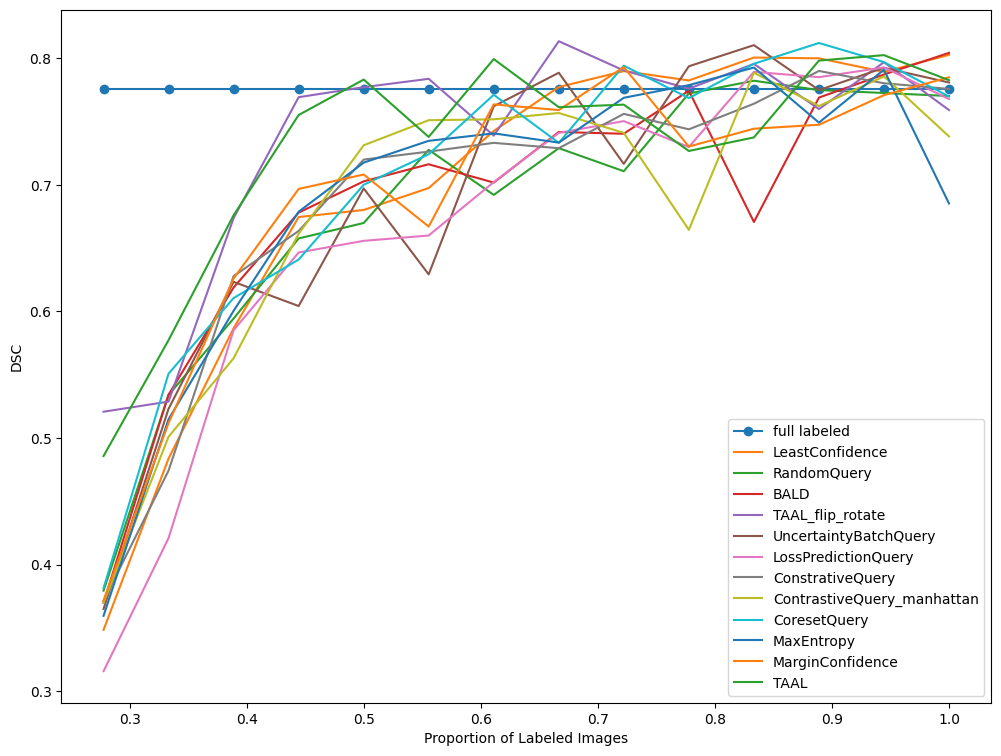

In [9]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(x, [full_dice] * 14, label="full labeled", marker="o")
for k, v in DSC.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("DSC")
ax.legend(fontsize=10)
plt.show()

In [ ]:
IoU["FullLabel"][-1]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(x, [full_iou] * 14, label="full labeled", marker="o")
for k, v in IoU.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("IoU")
ax.legend()
plt.show()

In [ ]:
ASSD["FullLabel"][-1]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(x, [full_assd] * 14, label="full labeled", marker="o")
for k, v in ASSD.items():
    if k != "FullLabel":
        print(k)
        ax.plot(x, v, label=k)
ax.set_xlabel("Proportion of Labeled Images")
ax.set_ylabel("ASSD")
ax.legend()
plt.show()